<a href="https://colab.research.google.com/github/dylanbforde/Cardiac-MRI-Segmentation/blob/main/Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Loading data

In [2]:
!pip install torchio
!pip install torchinfo
!pip install tensorboard
!pip install monai
!pip install timm

In [3]:
from pathlib import Path
from torch.utils.data import DataLoader
import torchio as tio
import numpy as np
import torch


In [4]:
def get_subjects(image_dir, label_dir):
    image_paths = sorted(image_dir.glob('*.nii.gz'))
    label_paths = sorted(label_dir.glob('*.nii.gz'))
    assert len(image_paths) == len(label_paths)

    subjects = []
    for img_path, lbl_path in zip(image_paths, label_paths):
        subject = tio.Subject(
            mri=tio.ScalarImage(img_path),
            heart=tio.LabelMap(lbl_path)
        )
        subjects.append(subject)
    return subjects

In [5]:
def get_loaders(modality='SA', base_path='/content/drive/Shareddrives/Segmentation Data Split/processed_data', batch_size=4, num_workers=4,
                patch_size=(256, 256, 1), augment=True):

    assert modality in ['SA', 'LA'], "Modality must be 'SA' or 'LA'"

    base_path = Path(base_path)
    paths = {
        'train': {
            'images': base_path / 'train' / modality / 'images',
            'labels': base_path / 'train' / modality / 'labels',
        },
        'val': {
            'images': base_path / 'val' / modality / 'images',
            'labels': base_path / 'val' / modality / 'labels',
        },
        'test': {
            'images': base_path / 'test' / modality / 'images',
            'labels': base_path / 'test' / modality / 'labels',
        }
    }


    # Standardize voxel spacing (in millimeters) BEFORE any spatial aug ---
    # This makes geometry transforms consistent across scans of different resolutions.
    pre = [tio.Resample((1.25, 1.25, 5.0)), ] # (in_plane_x, in_plane_y, slice_thickness)

    # Gentle augmentations applied BEFORE cropping
    # Doing aug before CropOrPad prevents black triangles from rotations/zoom-out
    # and keeps more context during the transform.
    augs = [
        tio.RandomFlip(axes=(0, 1), flip_probability=0.3), # Light in-plane flips. We keep depth (axis=2) unchanged to avoid odd slice reorderings.

        # Very mild affine to avoid destructive distortions
        tio.RandomAffine(
            scales=(1.00, 1.04),          # slight zoom-in only
            degrees=(0, 0, 3),            # in-plane rotation only (about the slice axis)
            translation=(1, 1, 0),        # mm; tiny shifts; 0 along depth to keep slices aligned
            isotropic=False,
            image_interpolation='linear', # smooth images
            label_interpolation='nearest',# keep masks crisp
            p=0.3
        ),

        # Intensity augmentations — gentle, image only.
        # Keep probabilities small so effects don’t stack aggressively.
        tio.RandomNoise(std=(0, 0.01), p=0.2, include=['mri']),
        tio.RandomBiasField(coefficients=0.25, p=0.15, include=['mri']),  # mild B1 inhomogeneity
        tio.RandomGamma(log_gamma=(-0.12, 0.12), p=0.15, include=['mri']),# small contrast variation
    ]



    # Crop/Pad AFTER aug, then normalize
    # Cropping last ensures the patch is centered and free of rotation artifacts.
    # Normalization last gives the network a stable distribution regardless of aug.
    training_transform   = tio.Compose(pre + augs + [
        tio.CropOrPad(patch_size),                                    # center to target patch size
        tio.ZNormalization(masking_method=tio.ZNormalization.mean),]) # normalize non-zero voxels

    # Validation: no aug — just resample, center, normalize.
    validation_transform = tio.Compose(pre + [
        tio.CropOrPad(patch_size),
        tio.ZNormalization(masking_method=tio.ZNormalization.mean),])


    train_subjects = get_subjects(paths['train']['images'], paths['train']['labels'])
    val_subjects = get_subjects(paths['val']['images'], paths['val']['labels'])
    test_subjects = get_subjects(paths['test']['images'], paths['test']['labels'])

    train_dataset = tio.SubjectsDataset(train_subjects, transform=training_transform)
    val_dataset = tio.SubjectsDataset(val_subjects, transform=validation_transform)
    test_dataset = tio.SubjectsDataset(test_subjects, transform=validation_transform)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

    print("Done")

    return train_loader, val_loader, test_loader

In [6]:
train_loader, val_loader, test_loader = get_loaders(
    modality='SA',
    base_path='/content/drive/Shareddrives/Segmentation Data Split/processed_data',
    batch_size=2,
    num_workers=0,
    patch_size=(256, 256,1),
    augment=True
)

Done


Images shape: torch.Size([2, 1, 256, 256, 1])
Labels shape: torch.Size([2, 1, 256, 256, 1])
Subject keys: dict_keys(['mri', 'heart'])


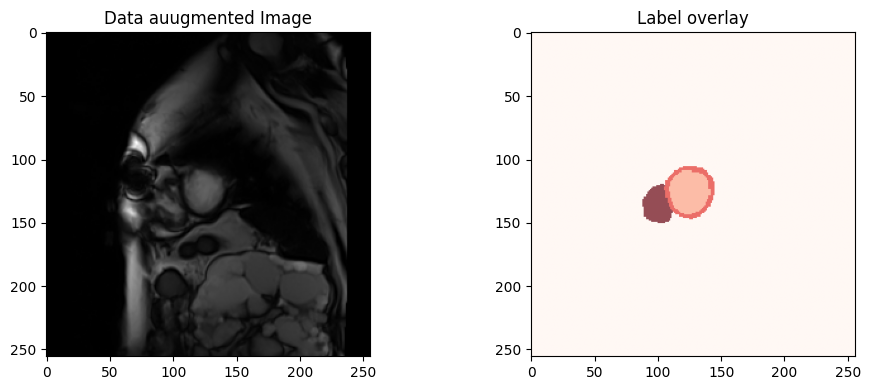

In [7]:
# This just tests it on a single batch to make sure everthing works

import matplotlib.pyplot as plt

batch = next(iter(train_loader))
images = batch['mri'][tio.DATA]
labels = batch['heart'][tio.DATA]

print(f"Images shape: {images.shape}")
print(f"Labels shape: {labels.shape}")
print(f"Subject keys: {batch.keys()}")

img_slice = images[0, 0, :, :, 0].numpy()
lbl_slice = labels[0, 0, :, :, 0].numpy()

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(img_slice, cmap='gray')
plt.title("Data auugmented Image")

plt.subplot(1, 2, 2)
plt.imshow(lbl_slice, cmap='Reds', alpha=0.7)
plt.title("Label overlay")

plt.tight_layout()
plt.show()

In [8]:
train_loader, val_loader, test_loader = get_loaders(
    modality='LA',
    base_path='/content/drive/Shareddrives/Segmentation Data Split/processed_data',
    batch_size=2,
    num_workers=0,
    patch_size=(256, 256,1),
    augment=True
)

Done


Images shape: torch.Size([2, 1, 256, 256, 1])
Labels shape: torch.Size([2, 1, 256, 256, 1])
Subject keys: dict_keys(['mri', 'heart'])


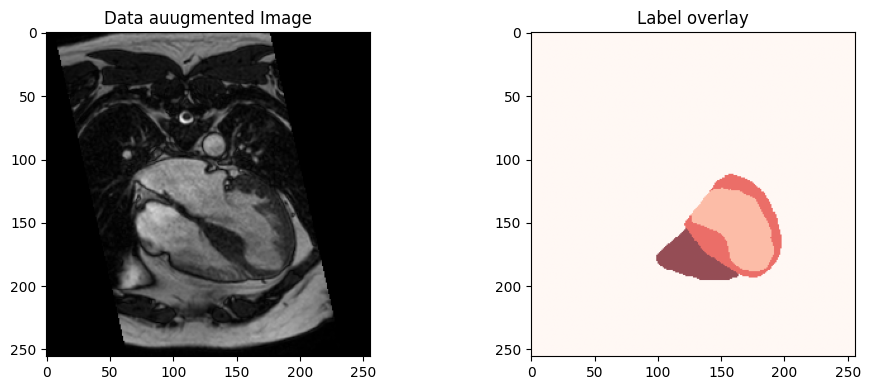

In [9]:
# This just tests it on a single batch to make sure everthing works

import matplotlib.pyplot as plt

batch = next(iter(train_loader))
images = batch['mri'][tio.DATA]
labels = batch['heart'][tio.DATA]

print(f"Images shape: {images.shape}")
print(f"Labels shape: {labels.shape}")
print(f"Subject keys: {batch.keys()}")

img_slice = images[0, 0, :, :, 0].numpy()
lbl_slice = labels[0, 0, :, :, 0].numpy()

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(img_slice, cmap='gray')
plt.title("Data auugmented Image")

plt.subplot(1, 2, 2)
plt.imshow(lbl_slice, cmap='Reds', alpha=0.7)
plt.title("Label overlay")

plt.tight_layout()
plt.show()

## Model

In [10]:
###################################
#      3D SegFormer Model
###################################

import torch
import torch.nn as nn
import torch.nn.functional as F
from timm.layers import DropPath

# 1. Overlapping Patch Embedding (3D)
class OverlapPatchEmbed3D(nn.Module):
    """
    Splits the input 3D volume into overlapping patches via a Conv3d layer
    and projects them into a token embedding space, followed by LayerNorm.
    """
    def __init__(self, img_size, patch_size, stride, in_chans, embed_dim):
        super().__init__()
        # img_size: (D, H, W), patch_size: (pD, pH, pW), stride: (sD, sH, sW)
        padding = tuple(p // 2 for p in patch_size)
        # 3D convolution to extract patch embeddings
        self.proj = nn.Conv3d(in_chans, embed_dim,
                              kernel_size=patch_size,
                              stride=stride,
                              padding=padding)
        # Layer normalization on the channel dimension
        self.norm = nn.LayerNorm(embed_dim)

    def forward(self, x):
        """
        Args:
            x: Input tensor of shape [B, C, D, H, W]
        Returns:
            tokens: Tensor of shape [B, N, embed_dim], where N = D'*H'*W'
            spatial_dims: Tuple (D', H', W') after projection
        """
        x = self.proj(x)  # [B, embed_dim, D', H', W']
        B, C, D, H, W = x.shape
        # flatten spatial dims, to [B, N, C]
        x = x.flatten(2).transpose(1, 2)
        x = self.norm(x)
        return x, (D, H, W)

# 2. Transformer Encoder Block
class TransformerBlock(nn.Module):
    """
    A single Transformer block: LayerNorm -> MHSA -> residual -> MLP -> residual.
    Supports stochastic depth via DropPath.
    """
    def __init__(self, dim, num_heads, mlp_ratio=4.0,
                 qkv_bias=True, drop=0.0, attn_drop=0.0, drop_path=0.0):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim)
        self.attn = nn.MultiheadAttention(dim, num_heads,
                                          dropout=attn_drop,
                                          bias=qkv_bias)
         # DropPath for stochastic depth regularization
        self.drop_path = DropPath(drop_path) if drop_path > 0.0 else nn.Identity()
        self.norm2 = nn.LayerNorm(dim)
        # MLP with two linear layers and a GELU activation
        self.mlp = nn.Sequential(
            nn.Linear(dim, int(dim * mlp_ratio)),
            nn.GELU(),
            nn.Linear(int(dim * mlp_ratio), dim),
            nn.Dropout(drop)
        )

    def forward(self, x):
        """
        Args:
            x: Tensor of shape [B, N, C]
        Returns:
            Tensor of shape [B, N, C]
        """
        B, N, C = x.size()
        shortcut = x
        x = self.norm1(x)
        x = x.transpose(0, 1) # MHSA expects sequence-first format [N, B, C]
        x, _ = self.attn(x, x, x)
        x = x.transpose(0, 1)
        x = shortcut + self.drop_path(x) # Residual connection + stochastic depth
        x = x + self.drop_path(self.mlp(self.norm2(x))) # MLP with residual and drop path
        return x

# 3. MiT‑backbone for 3D
class MixTransformer3D(nn.Module):
    """
    Hierarchical Vision Transformer backbone adapted for 3D volumes.
    Consists of multiple stages with overlapping patch embeddings and Transformer blocks.
    """
    def __init__(self,
                 img_size=(1, 256, 256),
                 in_chans=1,
                 embed_dims=[64, 128, 320, 512],
                 num_heads=[1, 2, 5, 8],
                 mlp_ratios=[4, 4, 4, 4],
                 depths=[3, 4, 6, 3],
                 drop_path_rate=0.1):
        super().__init__()
        # Compute drop path schedule across all blocks
        total_blocks = sum(depths)
        dpr = [x.item() for x in torch.linspace(0, drop_path_rate, total_blocks)]
        cur = 0
        self.stages = nn.ModuleList()
        # Build each stage
        for i in range(len(depths)):
            # Spatial dimensions reduce by patch embed stride
            p_dim = img_size if i == 0 else tuple(max(1, dim // (2 ** i)) for dim in img_size)
            patch_size = (3, 3, 3)
            stride = (2, 2, 1)  # downsample X,Y;
            # Input channels for this stage
            in_ch = in_chans if i == 0 else embed_dims[i - 1]
            embed_dim = embed_dims[i]

            patch_embed = OverlapPatchEmbed3D(
                img_size=p_dim,
                patch_size=patch_size,
                stride=stride,
                in_chans=in_ch,
                embed_dim=embed_dim
            )
            # Stack Transformer blocks with scheduled drop path
            blocks = nn.ModuleList()
            for j in range(depths[i]):
                blocks.append(
                    TransformerBlock(
                        dim=embed_dim,
                        num_heads=num_heads[i],
                        mlp_ratio=mlp_ratios[i],
                        drop_path=dpr[cur + j]
                    )
                )
            cur += depths[i]
            # Collect stage modules
            self.stages.append(nn.ModuleList([patch_embed, blocks]))

    def forward(self, x):
        """
        Args:
            x: Input volume [B, C, D, H, W]
        Returns:
            features: List of feature maps from each stage, each of shape [B, C_i, D_i, H_i, W_i]
        """
        features = []
        for patch_embed, blocks in self.stages:
            x, (D, H, W) = patch_embed(x) # Apply patch embedding to get tokens
            for blk in blocks: # Process tokens through transformer blocks
                x = blk(x)
            B, N, C = x.size() # Reshape tokens back into 3D feature map
            feat = x.transpose(1, 2).view(B, C, D, H, W)
            features.append(feat)
            # Use output feature map as input to next stage
            x = feat
        return features

# 4. Decoder for 3D semantic segmentation
class SegFormerDecoder3D(nn.Module):
    """
    Simple MLP-style decoder that projects multi-scale features to a common dimension,
    upsamples them, concatenates, and applies a 1×1 classifier.
    """
    def __init__(self, feature_dims=[64, 128, 320, 512], decoder_dim=256, num_classes=21):
        super().__init__()
        # 1×1×1 convolutions to project each feature map to decoder_dim
        self.proj_layers = nn.ModuleList([
            nn.Conv3d(in_ch, decoder_dim, kernel_size=1)
            for in_ch in feature_dims
        ])
        # Classifier: reduce concatenated features and output num_classes channels
        self.classifier = nn.Sequential(
            nn.Conv3d(decoder_dim * len(feature_dims), decoder_dim, kernel_size=1),
            nn.BatchNorm3d(decoder_dim),
            nn.ReLU(),
            nn.Dropout3d(0.1),
            nn.Conv3d(decoder_dim, num_classes, kernel_size=1)
        )

    def forward(self, features):
        """
        Args:
            features: List of feature tensors from backbone
        Returns:
            logits: Segmentation logits at reduced resolution
        """
        # Determine target spatial resolution from the first feature
        target_size = features[0].shape[2:]
        up_feats = []
        # Project and upsample each feature map
        for feat, proj in zip(features, self.proj_layers):
            f = proj(feat)
            if f.shape[2:] != target_size:
                f = F.interpolate(f, size=target_size, mode='trilinear', align_corners=False)
            up_feats.append(f)
        # Concatenate along channel dimension and classify
        x = torch.cat(up_feats, dim=1)
        return self.classifier(x)

# 5. Full 3D SegFormer
class SegFormer3D(nn.Module):
    """
    Complete SegFormer architecture for 3D volumes: backbone + decoder + final upsampling.
    """
    def __init__(self,
                 img_size=(1, 256, 256),
                 in_chans=1,
                 num_classes=21,
                 decoder_dim=256,
                 **backbone_kwargs):
        super().__init__()
        # Backbone: hierarchical transformer feature extractor
        self.backbone = MixTransformer3D(
            img_size=img_size,
            in_chans=in_chans,
            **backbone_kwargs
        )
        # Decoder: projecting and classifying multi-scale features
        self.decoder = SegFormerDecoder3D(
            feature_dims=backbone_kwargs.get('embed_dims', [64,128,320,512]),
            decoder_dim=decoder_dim,
            num_classes=num_classes
        )

    def forward(self, x):
        """
        Args:
            x: Input tensor [B, C, D, H, W]
        Returns:
            seg_logits: Upsampled segmentation logits [B, num_classes, D, H, W]
        """
        features = self.backbone(x)
        seg = self.decoder(features)
        # Upsample to original resolution
        return F.interpolate(seg, size=x.shape[2:], mode='trilinear', align_corners=False)

In [11]:
# Smaller model configuration
model_config_small = {
    'embed_dims': [32, 64, 160, 256],
    'depths': [2, 2, 2, 2],
    'num_heads': [1, 2, 5, 8],
    'mlp_ratios': [4, 4, 4, 4],
}
model = SegFormer3D(
    img_size=(256, 256, 1),
    in_chans=1,
    num_classes=1,
    decoder_dim=128,
    **model_config_small
)
model

SegFormer3D(
  (backbone): MixTransformer3D(
    (stages): ModuleList(
      (0): ModuleList(
        (0): OverlapPatchEmbed3D(
          (proj): Conv3d(1, 32, kernel_size=(3, 3, 3), stride=(2, 2, 1), padding=(1, 1, 1))
          (norm): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
        )
        (1): ModuleList(
          (0): TransformerBlock(
            (norm1): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
            (attn): MultiheadAttention(
              (out_proj): NonDynamicallyQuantizableLinear(in_features=32, out_features=32, bias=True)
            )
            (drop_path): Identity()
            (norm2): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
            (mlp): Sequential(
              (0): Linear(in_features=32, out_features=128, bias=True)
              (1): GELU(approximate='none')
              (2): Linear(in_features=128, out_features=32, bias=True)
              (3): Dropout(p=0.0, inplace=False)
            )
          )
         

In [12]:
from torch.nn.functional import softmax
# ================================
#  Minimal Smoke Test for SegFormer3D
# ================================
# This snippet performs a quick validation of the 3D SegFormer model,
# ensuring that it produces outputs with the correct shape and that
# the predicted class probabilities are properly normalized.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

model.eval()
# Generate a synthetic 5D tensor representing a single 3D volume
# Tensor shape: [batch_size, channels, depth, height, width]
# Here: batch_size=1, channels=1 (grayscale), depth=1, height=256, width=256
with torch.no_grad():
    x = torch.randn(1, 1, 1, 256, 256, device=device)
    logits = model(x)

# Verify that the output tensor has the expected dimensions:
#    [batch_size, num_classes, depth, height, width]
# For example, if num_classes=3, we expect: [1, 3, 1, 256, 256]
print("Output shape:", logits.shape)

# Apply softmax along the class dimension to obtain probability maps
#    and confirm that probabilities sum to 1 at each voxel.
probs = softmax(logits, dim=1)       # [1, C, D, H, W]
s = probs.sum(dim=1)                 # [1, D, H, W]
print("Sum per voxel min/max:", s.min().item(), s.max().item())

Output shape: torch.Size([1, 1, 1, 256, 256])
Sum per voxel min/max: 1.0 1.0


In [13]:
# Model architecture visualisation
from torchinfo import summary
summary(
    model,
    input_size=(1,1,1,256,256),
    depth=4,
    col_names=('output_size','num_params'))

Layer (type:depth-idx)                                  Output Shape              Param #
SegFormer3D                                             [1, 1, 1, 256, 256]       --
├─MixTransformer3D: 1-1                                 [1, 32, 1, 128, 256]      --
│    └─ModuleList: 2-1                                  --                        --
│    │    └─ModuleList: 3-1                             --                        --
│    │    │    └─OverlapPatchEmbed3D: 4-1               [1, 32768, 32]            960
│    │    │    └─ModuleList: 4-2                        --                        25,408
│    │    └─ModuleList: 3-2                             --                        --
│    │    │    └─OverlapPatchEmbed3D: 4-3               [1, 16384, 64]            55,488
│    │    │    └─ModuleList: 4-4                        --                        99,968
│    │    └─ModuleList: 3-3                             --                        --
│    │    │    └─OverlapPatchEmbed3D: 4-5      

## Model Training

In [14]:
from monai.metrics import HausdorffDistanceMetric
import torch.optim as optim
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter
import torch.nn as nn
import os
import warnings

warnings.filterwarnings("ignore", category=UserWarning, module="torchio.data.image")


def dice_coefficient(pred, target, smooth=1e-5):
    pred = torch.sigmoid(pred)
    pred = (pred > 0.5).float()
    intersection = (pred * target).sum(dim=(2,3,4))
    union = pred.sum(dim=(2,3,4)) + target.sum(dim=(2,3,4))
    dice = (2. * intersection + smooth) / (union + smooth)
    return dice.mean()

class CombinedLoss(nn.Module):
    def __init__(self, alpha=0.5, gamma=2.0, weight=None, size_average=True):
        super(CombinedLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.bce_loss = nn.BCEWithLogitsLoss(weight=weight, size_average=size_average)

    def forward(self, inputs, targets, smooth=1):
        # Dice Loss
        dice_loss = 1 - dice_coefficient(inputs, targets, smooth)

        # Focal Loss
        bce = self.bce_loss(inputs, targets)
        bce_exp = torch.exp(-bce)
        focal_loss = self.alpha * (1-bce_exp)**self.gamma * bce

        return 2 * dice_loss + focal_loss

def save_model(model, path):
    """Saves the model state dictionary to a file."""
    if not os.path.exists(os.path.dirname(path)):
        os.makedirs(os.path.dirname(path))
    torch.save(model.state_dict(), path)
    print(f"Model saved to {path}")

def train_model(model, train_loader, val_loader, num_epochs=25, learning_rate=1e-4, save_path=None, accumulation_steps=4):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
    criterion = CombinedLoss()
    writer = SummaryWriter()

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        optimizer.zero_grad()
        for i, batch in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]")):
            images = batch['mri'][tio.DATA].to(device)
            labels = batch['heart'][tio.DATA].to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            loss = loss / accumulation_steps
            loss.backward()

            if (i + 1) % accumulation_steps == 0:
                optimizer.step()
                optimizer.zero_grad()

            train_loss += loss.item() * accumulation_steps

        train_loss /= len(train_loader)
        writer.add_scalar('Loss/train', train_loss, epoch)

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for batch in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]"):
                images = batch['mri'][tio.DATA].to(device)
                labels = batch['heart'][tio.DATA].to(device)

                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item()

        val_loss /= len(val_loader)
        writer.add_scalar('Loss/val', val_loss, epoch)

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    writer.close()
    if save_path:
        save_model(model, save_path)
    print("Training finished.")

In [15]:
# Get SA and LA data loaders
sa_train_loader, sa_val_loader, sa_test_loader = get_loaders(modality='SA', batch_size=1)
la_train_loader, la_val_loader, la_test_loader = get_loaders(modality='LA', batch_size=1)

# Smaller model configuration
model_config_small = {
    'embed_dims': [32, 64, 160, 256],
    'depths': [2, 2, 2, 2],
    'num_heads': [1, 2, 5, 8],
    'mlp_ratios': [4, 4, 4, 4],
}

# Train the SA model
print("Training SA model...")
sa_model = SegFormer3D(
    img_size=(256, 256, 1),
    in_chans=1,
    num_classes=1,
    decoder_dim=128,
    **model_config_small
)
sa_model_save_path = '/content/drive/MyDrive/MIA_assignment2/outputs/segformer_model_sa_small.pth'
train_model(
    sa_model,
    sa_train_loader,
    sa_val_loader,
    num_epochs=5,   #############
    learning_rate=1e-4,
    save_path=sa_model_save_path,
    accumulation_steps=4
)

# Train the LA model
print("Training LA model...")
la_model = SegFormer3D(
    img_size=(256, 256, 1),
    in_chans=1,
    num_classes=1,
    decoder_dim=128,
    **model_config_small
)
la_model_save_path = '/content/drive/MyDrive/MIA_assignment2/outputs/segformer_model_la_small.pth'
train_model(
    la_model,
    la_train_loader,
    la_val_loader,
    num_epochs=5, ##########
    learning_rate=1e-4,
    save_path=la_model_save_path,
    accumulation_steps=4
)

Done


/usr/local/lib/python3.11/dist-packages/torch/nn/_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


Done
Training SA model...


Epoch 1/5 [Val]: 100%|██████████| 3275/3275 [02:50<00:00, 19.26it/s]


Epoch 1/5, Train Loss: 1.5611, Val Loss: 1.5841


Epoch 2/5 [Val]: 100%|██████████| 3275/3275 [02:51<00:00, 19.07it/s]


Epoch 2/5, Train Loss: 1.5005, Val Loss: 1.4648


Epoch 3/5 [Val]: 100%|██████████| 3275/3275 [02:49<00:00, 19.33it/s]


Epoch 3/5, Train Loss: 1.4120, Val Loss: 1.4036


Epoch 4/5 [Val]: 100%|██████████| 3275/3275 [02:49<00:00, 19.30it/s]


Epoch 4/5, Train Loss: 1.2963, Val Loss: 1.2169


Epoch 5/5 [Val]: 100%|██████████| 3275/3275 [02:50<00:00, 19.20it/s]


Epoch 5/5, Train Loss: 1.1745, Val Loss: 1.0134
Model saved to /content/drive/MyDrive/MIA_assignment2/outputs/segformer_model_sa_small.pth
Training finished.
Training LA model...


Epoch 1/5 [Val]: 100%|██████████| 288/288 [00:15<00:00, 18.68it/s]


Epoch 1/5, Train Loss: 1.0416, Val Loss: 0.9124


Epoch 2/5 [Val]: 100%|██████████| 288/288 [00:15<00:00, 19.06it/s]


Epoch 2/5, Train Loss: 0.6893, Val Loss: 0.7848


Epoch 3/5 [Val]: 100%|██████████| 288/288 [00:15<00:00, 18.69it/s]


Epoch 3/5, Train Loss: 0.5598, Val Loss: 0.5781


Epoch 4/5 [Val]: 100%|██████████| 288/288 [00:15<00:00, 18.92it/s]


Epoch 4/5, Train Loss: 0.4946, Val Loss: 0.3953


Epoch 5/5 [Val]: 100%|██████████| 288/288 [00:15<00:00, 19.05it/s]

Epoch 5/5, Train Loss: 0.4515, Val Loss: 0.3420
Model saved to /content/drive/MyDrive/MIA_assignment2/outputs/segformer_model_la_small.pth
Training finished.


Visualizing predictions for SA model...


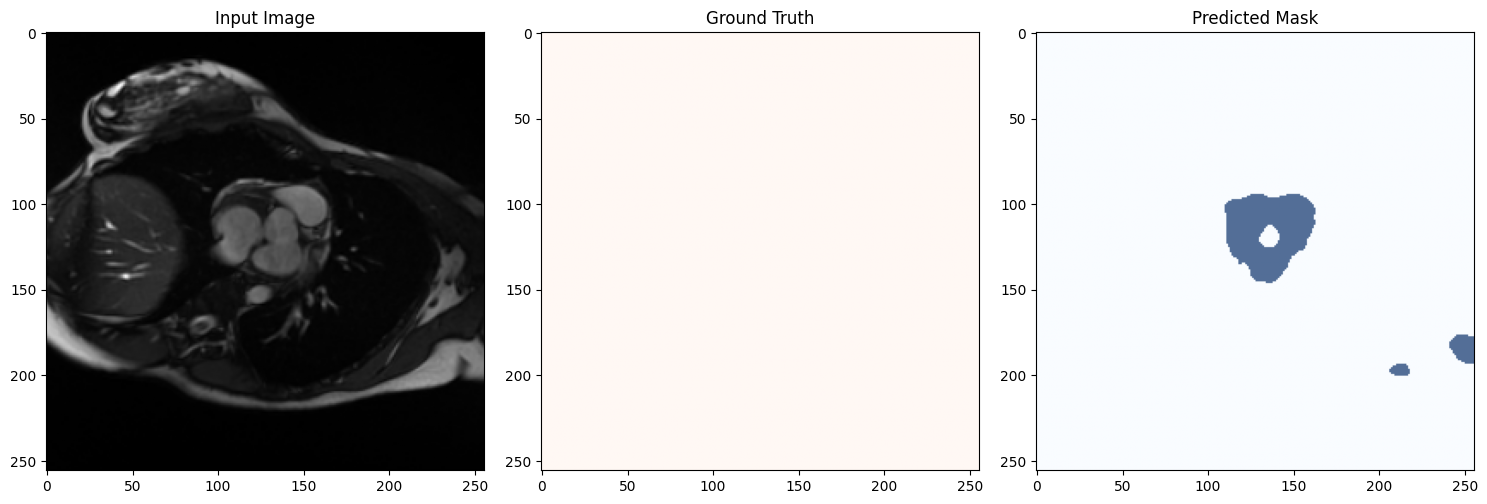

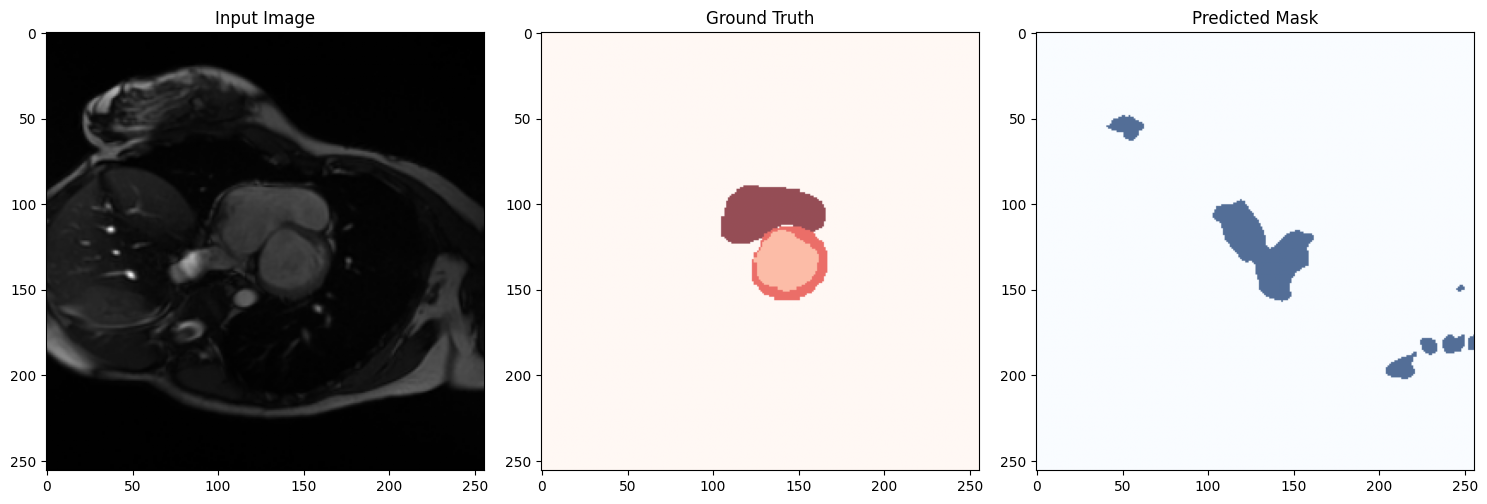

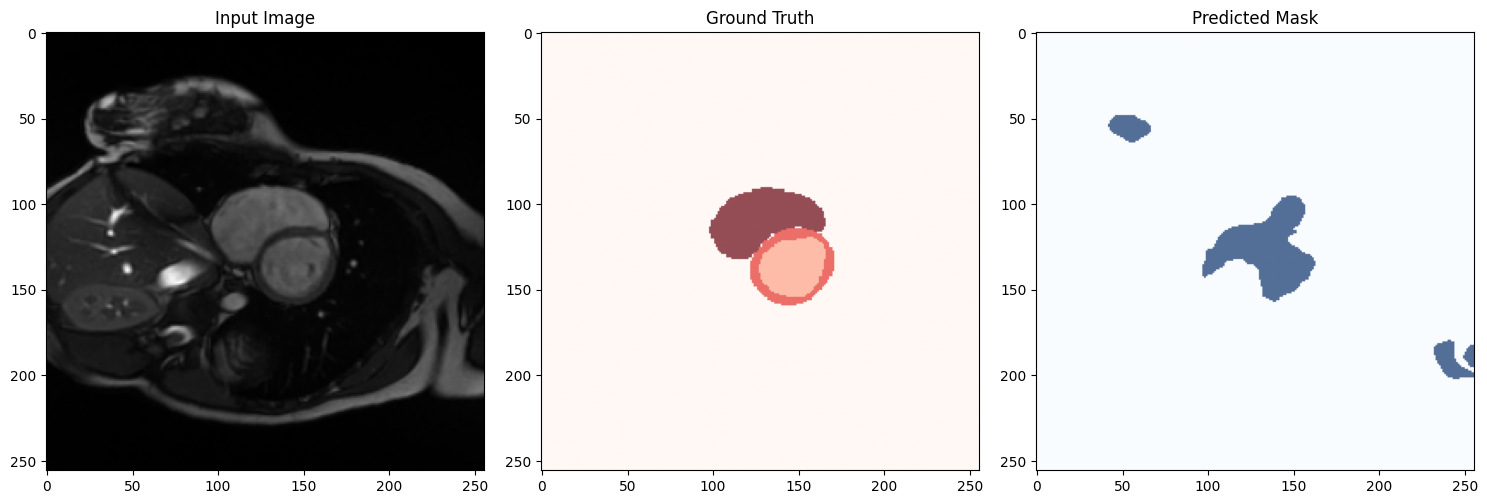


Visualizing predictions for LA model...


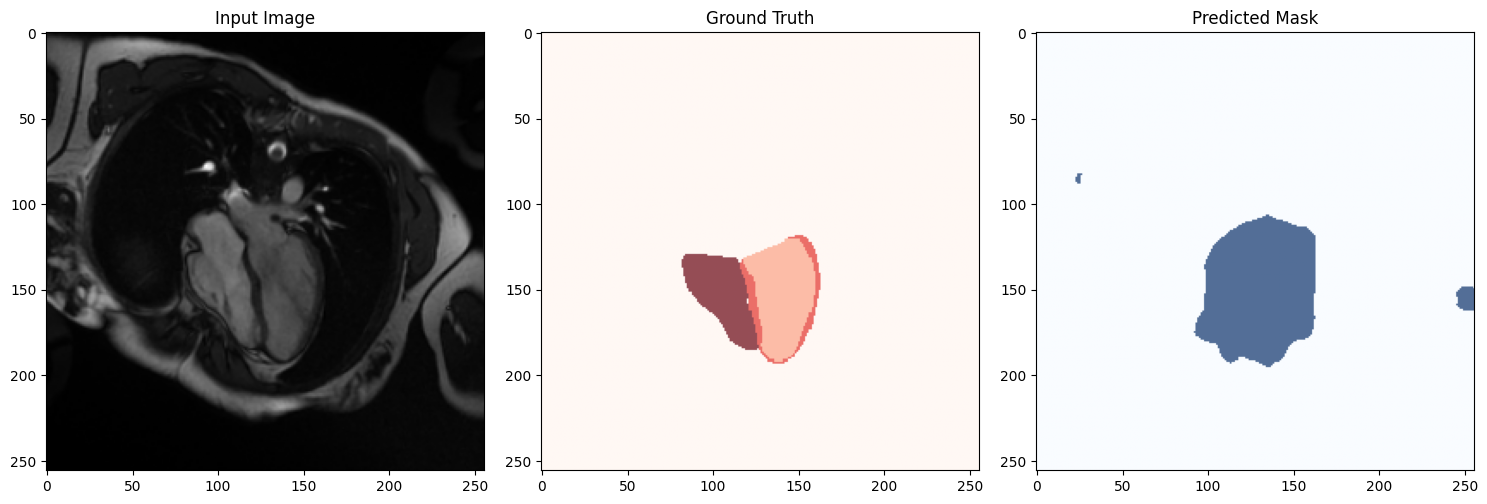

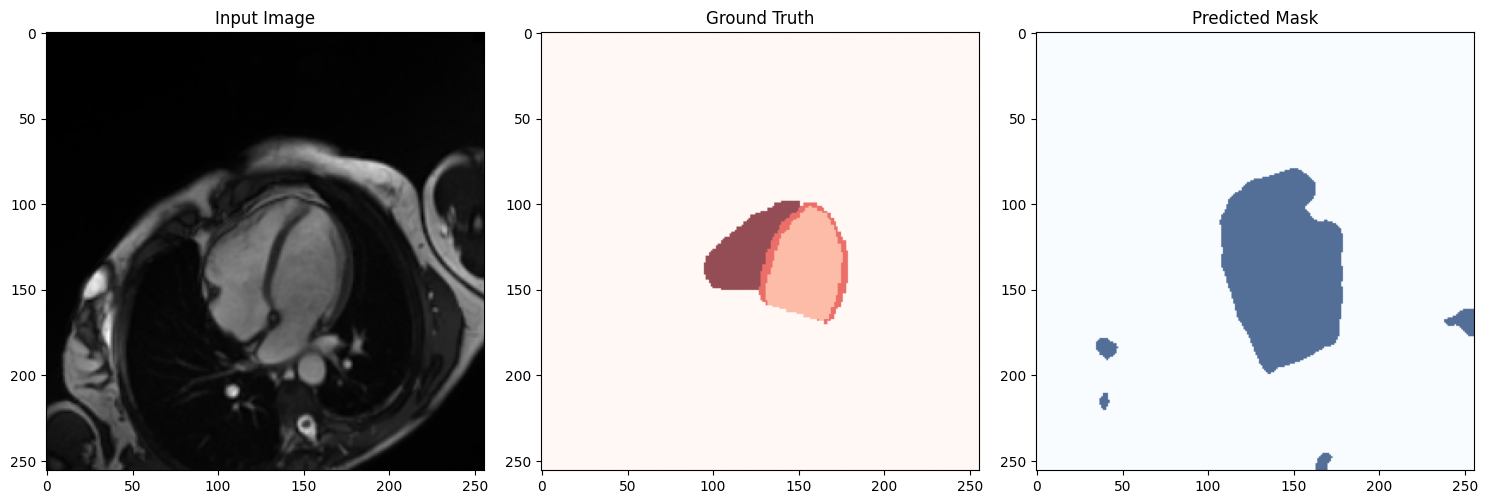

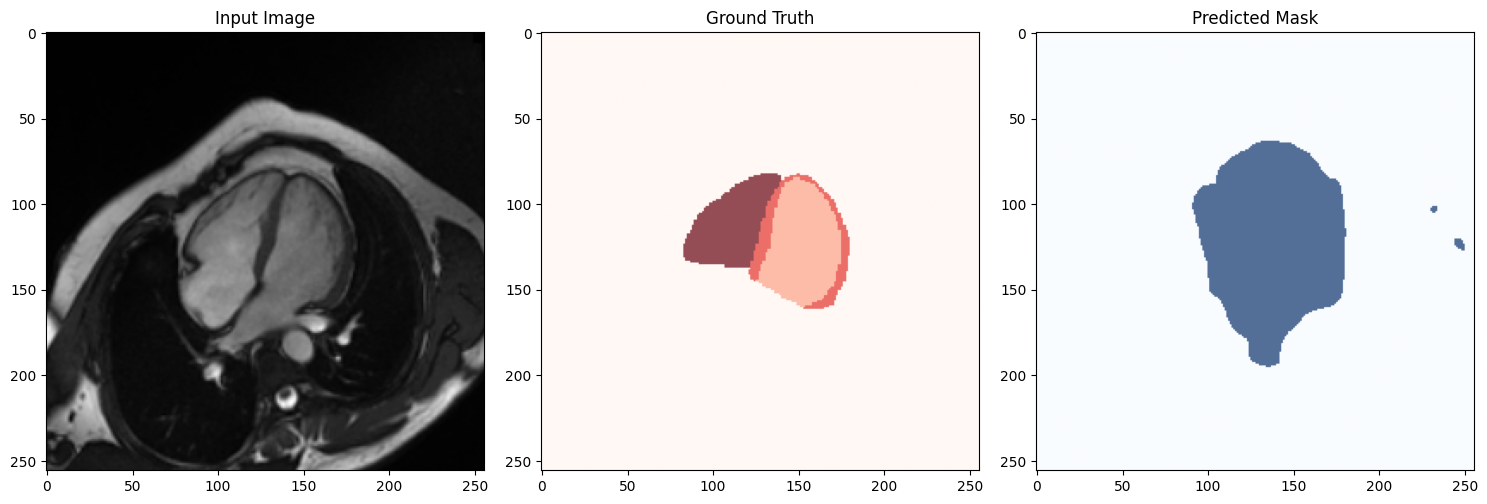

In [16]:
import matplotlib.pyplot as plt
import torch

def visualize_predictions(model, loader, num_samples=3):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    with torch.no_grad():
        for i, batch in enumerate(loader):
            if i >= num_samples:
                break

            images = batch['mri'][tio.DATA].to(device)
            labels = batch['heart'][tio.DATA].to(device)

            outputs = model(images)
            preds = torch.sigmoid(outputs) > 0.5

            img_slice = images[0, 0, :, :, 0].cpu().numpy()
            lbl_slice = labels[0, 0, :, :, 0].cpu().numpy()
            pred_slice = preds[0, 0, :, :, 0].cpu().numpy()

            plt.figure(figsize=(15, 5))

            plt.subplot(1, 3, 1)
            plt.imshow(img_slice, cmap='gray')
            plt.title('Input Image')

            plt.subplot(1, 3, 2)
            plt.imshow(lbl_slice, cmap='Reds', alpha=0.7)
            plt.title('Ground Truth')

            plt.subplot(1, 3, 3)
            plt.imshow(pred_slice, cmap='Blues', alpha=0.7)
            plt.title('Predicted Mask')

            plt.tight_layout()
            plt.show()

# Visualize predictions for the SA model on the test set
print("Visualizing predictions for SA model...")
visualize_predictions(sa_model, sa_test_loader)

# Visualize predictions for the LA model on the test set
print("\nVisualizing predictions for LA model...")
visualize_predictions(la_model, la_test_loader)

## Evaluation

In [17]:
from monai.metrics import HausdorffDistanceMetric
import torch.optim as optim
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import torch.nn as nn
import os
import warnings
import pandas as pd
import statistics

# Define Hausdorff metric
hd_metric = HausdorffDistanceMetric(include_background=False, reduction="mean", percentile=95)

def test_model(model, test_loader, device, save_csv_path=None, save_model_path=None):
    model.eval()

    dice_scores = []
    hausdorff_scores = []
    precision_scores = []
    recall_scores = []
    f1_scores = []

    # Create a DataFrame to store per-sample results
    results_df = pd.DataFrame(columns=['Sample_Index', 'Dice', 'Hausdorff', 'Precision', 'Recall', 'F1'])

    with torch.no_grad():
        for batch_idx, batch in enumerate(tqdm(test_loader, desc="Testing")):
            images = batch['mri'][tio.DATA].to(device)
            labels = batch['heart'][tio.DATA].to(device)

            outputs = model(images)
            preds = torch.sigmoid(outputs) > 0.5  # Binary prediction

            # Compute Dice
            current_dice = dice_coefficient(outputs, labels).item()
            dice_scores.append(current_dice)

            # Compute Hausdorff Distance using MONAI
            # MONAI expects [B, C, H, W, D], and for binary, we can treat as single class
            hd_metric(y_pred=preds, y=labels)
            current_hd = hd_metric.aggregate().item()
            hd_metric.reset()  # Reset for next batch
            hausdorff_scores.append(current_hd)

            # Flatten predictions and labels
            y_true = labels.cpu().numpy().astype(int).flatten()
            y_pred = preds.cpu().numpy().astype(int).flatten()

            y_true = (y_true > 0).astype(int)
            y_pred = (y_pred > 0).astype(int)

            precision = precision_score(y_true, y_pred, average='binary', zero_division=0)
            recall = recall_score(y_true, y_pred, average='binary', zero_division=0)
            f1 = f1_score(y_true, y_pred, average='binary', zero_division=0)


            precision_scores.append(precision)
            recall_scores.append(recall)
            f1_scores.append(f1)

            results_df = pd.concat([results_df, pd.DataFrame([{
                'Sample_Index': batch_idx,
                'Dice': current_dice,
                'Hausdorff': current_hd,
                'Precision': precision,
                'Recall': recall,
                'F1': f1
            }])], ignore_index=True)

    # Averages
    avg_dice = statistics.mean(dice_scores)
    avg_hausdorff = statistics.mean(hausdorff_scores)
    avg_precision = statistics.mean(precision_scores)
    avg_recall = statistics.mean(recall_scores)
    avg_f1 = statistics.mean(f1_scores)

    print("\nAverages:")
    print(f"Dice:      {avg_dice:.4f}")
    print(f"Hausdorff: {avg_hausdorff:.4f}")
    print(f"Precision: {avg_precision:.4f}")
    print(f"Recall:    {avg_recall:.4f}")
    print(f"F1 Score:  {avg_f1:.4f}")

    if save_csv_path:
        results_df.to_csv(save_csv_path, index=False)
        print(f"Results saved to {save_csv_path}")

    if save_model_path:
        save_model(model, save_model_path)

    return results_df

In [18]:
# Get SA and LA data loaders
sa_train_loader, sa_val_loader, sa_test_loader = get_loaders(modality='SA', batch_size=1)
la_train_loader, la_val_loader, la_test_loader = get_loaders(modality='LA', batch_size=1)

# Smaller model configuration
model_config_small = {
    'embed_dims': [32, 64, 160, 256],
    'depths': [2, 2, 2, 2],
    'num_heads': [1, 2, 5, 8],
    'mlp_ratios': [4, 4, 4, 4],
}

# Re-instantiate SA model and load weights
sa_model = SegFormer3D(
    img_size=(256, 256, 1),
    in_chans=1,
    num_classes=1,
    decoder_dim=128,
    **model_config_small
)
sa_model.load_state_dict(torch.load('/content/drive/MyDrive/MIA_assignment2/outputs/segformer_model_sa_small.pth'))
sa_model.to(device)
sa_model.eval()  # Set to evaluation mode

# Similarly for LA model
la_model = SegFormer3D(
    img_size=(256, 256, 1),
    in_chans=1,
    num_classes=1,
    decoder_dim=128,
    **model_config_small
)

la_model.load_state_dict(torch.load('/content/drive/MyDrive/MIA_assignment2/outputs/segformer_model_la_small.pth'))
la_model.to(device)
la_model.eval()  # Set to evaluation mode

Done
Done


SegFormer3D(
  (backbone): MixTransformer3D(
    (stages): ModuleList(
      (0): ModuleList(
        (0): OverlapPatchEmbed3D(
          (proj): Conv3d(1, 32, kernel_size=(3, 3, 3), stride=(2, 2, 1), padding=(1, 1, 1))
          (norm): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
        )
        (1): ModuleList(
          (0): TransformerBlock(
            (norm1): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
            (attn): MultiheadAttention(
              (out_proj): NonDynamicallyQuantizableLinear(in_features=32, out_features=32, bias=True)
            )
            (drop_path): Identity()
            (norm2): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
            (mlp): Sequential(
              (0): Linear(in_features=32, out_features=128, bias=True)
              (1): GELU(approximate='none')
              (2): Linear(in_features=128, out_features=32, bias=True)
              (3): Dropout(p=0.0, inplace=False)
            )
          )
         

In [19]:
# Evaluate SA model
print("Evaluating SA model...")
sa_results = test_model(sa_model, sa_test_loader, device, save_csv_path="sa_results.csv", save_model_path="/content/drive/MyDrive/MIA_assignment2/outputs/sa_small_evaluated.pth")


Evaluating SA model...


Testing:   0%|          | 0/1599 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/monai/utils/deprecate_utils.py:221: FutureWarning: monai.metrics.utils get_mask_edges:always_return_as_numpy: Argument `always_return_as_numpy` has been deprecated since version 1.5.0. It will be removed in version 1.7.0. The option is removed and the return type will always be equal to the input type.
  warn_deprecated(argname, msg, warning_category)
/usr/local/lib/python3.11/dist-packages/monai/metrics/utils.py:327: UserWarning: the ground truth of class 0 is all 0, this may result in nan/inf distance.
  warnings.warn(
/tmp/ipython-input-1966783385.py:62: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, pd.DataFrame([{


Averages:
Dice:      0.5185
Hausdorff: 58.4407
Precision: 0.4203
Recall:    0.4444
F1 Score:  0.4125
Results saved to sa_results.csv
Model saved to /content/drive/MyDrive/MIA_assignment2/outputs/sa_small_evaluated.pth


In [28]:
!pip install grad-cam
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
import numpy as np
import matplotlib.pyplot as plt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 64.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.5.5-py3-none-any.whl size=44284 sha256=5e02666e205ee354512589adb3c0681f84fdfedb9404a5798554ebb6232441bb
  Stored in directory: /root/.cache/pip/wheels/bc/52/78/893c3b94279ef238f43a9e89608af648de401b96415bebbd1f
Successfully built grad-cam


In [29]:
def apply_gradcam(model, loader, target_layer, num_samples=3):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    cam = GradCAM(model=model, target_layers=[target_layer])

    for i, batch in enumerate(loader):
        if i >= num_samples:
            break

        images = batch['mri'][tio.DATA].to(device)
        labels = batch['heart'][tio.DATA].to(device)

        # CAM expects numpy image [H, W, C] in range [0,1]
        img_slice = images[0, 0, :, :, 0].cpu().numpy()
        rgb_image = np.stack([img_slice]*3, axis=-1)
        rgb_image = (rgb_image - rgb_image.min()) / (rgb_image.max() - rgb_image.min())

        # Grad-CAM for binary segmentation — we can just set target to None or use ClassifierOutputTarget(0)
        grayscale_cam = cam(input_tensor=images, targets=None)
        grayscale_cam = grayscale_cam[0, :, :, 0]  # take depth=0 slice

        # Overlay
        cam_image = show_cam_on_image(rgb_image, grayscale_cam, use_rgb=True)

        # Plot
        plt.figure(figsize=(12,4))
        plt.subplot(1,3,1)
        plt.imshow(img_slice, cmap='gray')
        plt.title('Input')

        plt.subplot(1,3,2)
        plt.imshow(labels[0, 0, :, :, 0].cpu().numpy(), cmap='Reds', alpha=0.6)
        plt.title('Ground Truth')

        plt.subplot(1,3,3)
        plt.imshow(cam_image)
        plt.title('Grad-CAM')

        plt.tight_layout()
        plt.show()


In [30]:
target_layer = sa_model.decoder.classifier[-1]  # final conv layer in decoder

print("Grad-CAM on SA model...")
apply_gradcam(sa_model, sa_test_loader, sa_model.decoder.classifier[-1])

Grad-CAM on SA model...


RuntimeError: grad can be implicitly created only for scalar outputs